<a href="https://colab.research.google.com/github/shulifinley/poly-or-rand/blob/main/galois_DL2_coef_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install galois

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import galois
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import math


In [ ]:
import torch

%matplotlib inline

from IPython.display import Image, display
import tensorflow as tf
import random

import torchvision.models as models
import time

from torch import nn
from PIL import Image

import torch.nn.functional as F

from torch import optim

In [ ]:
galois.__version__

'0.3.5'

In [ ]:
!pip install graphviz
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchviz import make_dot


In [ ]:
# function to convert function evaluations to flattened one-hot encoding vector
def evals_to_one_hot(GF, e_array, evals):
  q = GF.characteristic
  eval_one_hot = GF.Zeros((q, q))
  eval_one_hot[e_array, evals] = 1
  eval_one_hot = eval_one_hot.flatten()
  return eval_one_hot

In [ ]:
def expand_greyscale_image_channels(grey_image, desired_channels):
    # grey_image_arr = np.array(grey_image)
    grey_image_arr = np.expand_dims(grey_image, -1)
    grey_image_arr_channels = grey_image_arr.repeat(desired_channels, axis=-1)
    return grey_image_arr_channels

In [ ]:
def generate_data(q, d, num_instances, pi=None):
  GF = galois.GF(q**1)
  # array of field elements
  e_array = GF.Range(0,q)
  data = {
      'pre_permutation' : np.empty(num_instances, dtype=object),
      'data' : np.empty(num_instances, dtype=object)
  }

  for i in range(num_instances):
    # polynomials
    poly_array = np.array([galois.Poly.Random(degree=d, field=GF) for i in range(q**2)])
    # print('poly array shape ', poly_array.shape)

    evals_array = np.array([evals_to_one_hot(GF, e_array, f(e_array)).flatten() for f in poly_array])
    # print('evals array shape ', evals_array.shape)
    if pi is not None:
      # print(pi)
      data['pre_permutation'][i] = expand_greyscale_image_channels(evals_array, q)
      evals_array = np.array([list(map(eval.__getitem__, pi)) for eval in evals_array])
      # print(evals_array)

    data['data'][i] = expand_greyscale_image_channels(evals_array, q) #GF(evals_array)
  # print('data[0] shape ', data[0].shape)

  return data



In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class ShuliDataset(Dataset):

    def __init__(self, X, transform=None):
        self.X = X
        self.transform = transform
        self.labels = np.array([1 for x in range(int(len(X)/2))] + [0 for x in range(int(len(X)/2))])
        self.labels = torch.from_numpy(self.labels.astype('int'))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.X[idx]
        label = self.labels[idx]
        sample = {'image': image, 'label': label}

        if self.transform:
          sample = {'image': self.transform(image), 'label': label}

        return sample

In [ ]:
# to check train / validation overlap

# def view1D(a, b): # a, b are arrays
#   shape = a.shape
#   print(shape, a[1].shape)
#   print(a[0])
#   a = a.reshape(shape[0], shape[1], shape[2]*shape[3])
#   a = np.array([x.astype(int) for x in a])
#   a = np.ascontiguousarray(a)

#   shape = b.shape
#   b = b.reshape(shape[0], shape[1], shape[2]*shape[3])
#   b = b.astype(int)
#   b = np.ascontiguousarray(b)
#   void_dt = np.dtype((np.void, a.dtype.itemsize * a.shape[1]))
#   print('array dtype' + str(a.dtype))
#   return a.view(void_dt).ravel(),  b.view(void_dt).ravel()


# def isin_nd_searchsorted(a,b):
#   # a,b are the 3D input arrays
#   A,B = view1D(a.reshape(a.shape[0],-1),b.reshape(b.shape[0],-1))
#   sidx = A.argsort()
#   sorted_index = np.searchsorted(A,B,sorter=sidx)
#   sorted_index[sorted_index==len(A)] = len(A)-1
#   idx = sidx[sorted_index]
#   return A[idx] == B

In [ ]:
# def show_image_idx(figure, dataset, sample_idx):
#   # sample_idx = np.random.choice(len(dataset))
#   sample = dataset[sample_idx]
#   label = sample['label']
#   figure.add_subplot(rows, cols, i)
#   plt.title('sample #{0}, label: {1}'.format(sample_idx, sample['label']))
#   plt.axis("off")
#   img = sample['image'].squeeze(0)
#   npimg = img.numpy()
#   plt.imshow(npimg[0])

def show_dataset(dataset, q, d, title_addition=None, sample_idx=None):
  figure = plt.figure(figsize=(9, 8))
  title = "q = " + str(q) + ", label 1 for d = " + str(d)
  if title_addition is not None:
    title += '\n' + str(title_addition)
  figure.suptitle(title)
  cols, rows = 3, 3
  if sample_idx is None:
    sample_idx = np.random.choice(len(dataset), size=(cols*rows), replace=False)

  for i in range(1, cols * rows + 1):
      # sample_idx = np.random.choice(len(dataset))
      sample = dataset[sample_idx[i-1]]
      label = sample['label']
      axes = figure.add_subplot(rows, cols, i)
      plt.title('sample #{0}, label: {1}'.format(sample_idx[i-1], sample['label']))
      plt.subplots_adjust(hspace=0.3, wspace=0.4)
      # plt.axis("off")
      # plt.xticks(np.arange(0, q, int(math.sqrt(q))))
      axes.xaxis.set_major_locator(MaxNLocator(nbins=q,integer=True))
      axes.yaxis.set_major_locator(MaxNLocator(nbins=q,integer=True))
      img = sample['image'].squeeze(0)
      npimg = img.numpy()
      plt.imshow(npimg[0])
      axes = plt.gca()
      axes.invert_yaxis()
  plt.show()
  return sample_idx

  # if pre_permutation is not None:
  #   f, (ax1, ax2) = plt.subplots(2, 1)
  #   for i in range(1, cols * rows + 1):
  #       # sample_idx = np.random.choice(len(dataset))
  #       sample = pre_permutation[sample_idx[i]]
  #       label = sample['label']
  #       ax1.add_subplot(rows, cols, i)
  #       ax1.set_title('sample #{0}, label: {1}'.format(sample_idx, sample['label']))
  #       # plt.axis("off")
  #       img = sample['image'].squeeze(0)
  #       npimg = img.numpy()
  #       plt.imshow(npimg[0])
  #   plt.show()
  #   for i in range(1, cols * rows + 1):
  #       # sample_idx = np.random.choice(len(dataset))
  #       sample = dataset[sample_idx[i]]
  #       label = sample['label']
  #       ax2.add_subplot(rows, cols, i)
  #       ax2.set_title('sample #{0}, label: {1}'.format(sample_idx, sample['label']))
  #       # plt.axis("off")
  #       img = sample['image'].squeeze(0)
  #       npimg = img.numpy()
  #       plt.imshow(npimg[0])
  #   plt.show()

  # else:



In [ ]:
class Net_coef_filter(nn.Module):
    def __init__(self):
        super(Net_coef_filter, self).__init__()
        self.conv1 = nn.Conv2d(q, q, (q**2,q), stride=(1,q))
        self.fc1 = nn.Linear(q**2, q**2)
        self.fc2 = nn.Linear(q**2, 2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = x.view(-1, q**2)
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        x = F.softmax(self.fc2(x))
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def calc_acc(net, dataloader):
  total_correct = 0
  total_images = 0
  net.eval()

  with torch.no_grad():
      for i, data in enumerate(dataloader, 0):
          inputs, labels = data['image'], data['label']
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total_images += labels.size(0)
          total_correct += (predicted == labels).sum().item()

  model_accuracy = total_correct / total_images
  return model_accuracy

In [ ]:
def train_model(net, train_dataloader, val_dataloader, epochs):
  since = time.time()
  net = net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters())

  train_loss_list = []
  train_acc_list = []

  val_loss_list = []
  val_acc_list = []

  for epoch in range(epochs):  # loop over the dataset multiple times
      print()
      print('Epoch: ', epoch)
      train_running_loss = 0.0
      train_total_correct = 0
      train_total_images = 0
      net.train()

      for i, data in enumerate(train_dataloader, 0):
          inputs, labels = data['image'], data['label']
          inputs = inputs.to(device)
          labels = labels.to(device)
          # print (inputs[0], labels[0])
          # zero the parameter gradients
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

          # print statistics
          train_running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          train_total_images += labels.size(0)
          train_total_correct += (predicted == labels).sum().item()

      # print('Training loss: %.3f' % (train_running_loss))
      train_loss_list.append(train_running_loss/len(train_dataloader))

      model_accuracy = train_total_correct / train_total_images * 100
      print('Training batch accuracy: {0:.2f}%'.format(model_accuracy))
      train_acc_list.append(model_accuracy/100)

      # running validation
      net.eval()
      val_running_loss = 0.0
      val_total_correct = 0
      val_total_images = 0

      with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
          inputs, labels = data['image'], data['label']
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = net(inputs) # if using CNN

          loss = criterion(outputs, labels)

          # print statistics
          val_running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          val_total_images += labels.size(0)
          val_total_correct += (predicted == labels).sum().item()

      # print('Validation loss: %.3f' % (val_running_loss))
      val_loss_list.append(val_running_loss/len(val_dataloader))

      model_accuracy = val_total_correct / val_total_images * 100
      print('Validation batch accuracy: {0:.2f}%'.format(model_accuracy))
      val_acc_list.append(model_accuracy/100)

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))

  return {
      'net': net,
      'train_loss_list': train_loss_list,
      'val_loss_list': val_loss_list,
      'train_acc_list': train_acc_list,
      'val_acc_list': val_acc_list
  }

In [ ]:
def run_model(net, q, d, num_instances, num_epochs=10, pi=None):
  # print(' Model type: {0}, \n Shifts type: {1},\n Number of training data points: {2},\n Number of validation data points: {3}'.format(model_type, fixed_or_random, len(train_data), len(validation_data)))
  if pi is not None:
    print('Permutation pi:')
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle('Permutation Visualization')
    axs[0].imshow(np.arange(q**2).reshape(q,q))
    axs[0].invert_yaxis()
    axs[1].imshow(pi.reshape(q,q))
    axs[1].invert_yaxis()
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()


  transform = transforms.Compose(
    [transforms.ToTensor()])

  # training data
  low_deg_data = generate_data(q, d=d, num_instances=num_instances, pi=pi)
  rand_deg_data = generate_data(q, d=q-1, num_instances=num_instances, pi=pi)
  X = np.concatenate([low_deg_data['data'], rand_deg_data['data']], axis=0).astype('object')
  train_dataset = ShuliDataset(X, transform)

  # permutation
  sample_idx=None
  title_addition=None
  if pi is not None:
    X_pre_permutation = np.concatenate([low_deg_data['pre_permutation'], rand_deg_data['pre_permutation']], axis=0).astype('object')
    train_pre_permutation = ShuliDataset(X_pre_permutation, transform)
    sample_idx = show_dataset(train_pre_permutation, q, d, title_addition='data pre permutation')
    title_addition='data post permutation'
    plt.show()

  show_dataset(train_dataset, q, d, title_addition = title_addition, sample_idx=sample_idx)
  plt.show()

  # validation data
  low_deg_data = generate_data(q, d=d, num_instances=int(0.2*num_instances), pi=pi)
  rand_deg_data = generate_data(q, d=q-1, num_instances=int(0.2*num_instances), pi=pi)

  X_val = np.concatenate([low_deg_data['data'], rand_deg_data['data']], axis=0).astype('object')
  val_dataset = ShuliDataset(X_val, transform)

  # # checking train / validation overlap

  # overlap = isin_nd_searchsorted(X,X_val).sum()

  # print("train set size: {}, validation set size {}".format(len(X), len(X_val)))
  # print('Overlap:  {}, % of validation = {}'.format(overlap, (overlap)//len(X_val)))


  # print()

  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True, num_workers=4)


  results = train_model(net, train_dataloader, val_dataloader, num_epochs)
  net = results['net']
  train_loss_list = results['train_loss_list']
  val_loss_list = results['val_loss_list']
  train_acc_list = results['train_acc_list']
  val_acc_list = results['val_acc_list']

  print()
  final_train_acc = calc_acc(net, train_dataloader)
  print('Final training accuracy: %.3f' % (final_train_acc))
  final_val_acc = calc_acc(net, val_dataloader)
  print('Final validation accuracy: %.3f' % (final_val_acc))

  # testing
  low_deg_data, rand_deg_data = generate_data(q, d=d, num_instances=1000, pi=pi), generate_data(q, d=q-1, num_instances=1000, pi=pi)
  X = np.concatenate([low_deg_data['data'], rand_deg_data['data']], axis=0).astype('object')
  test_dataset = ShuliDataset(X, transform)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)
  final_test_acc = calc_acc(net, test_dataloader)
  print('Final test accuracy: %.3f' % (final_test_acc))

  epochs = np.array(range(num_epochs))

  plt.plot(epochs, train_acc_list, 'o-', alpha=0.8, label='Training')
  plt.plot(epochs, val_acc_list, 'o-', label='Validation')
  plt.legend()
  title = 'Accuracy per epoch for ' + 'q=' + str(q) + ', d=' + str(d)
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

  plt.plot(epochs, train_loss_list, 'o-', alpha=0.8, label='Training')
  plt.plot(epochs, val_loss_list, 'o-', label='Validation')
  plt.legend()
  plt.title("Loss per Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  return results


In [ ]:
# q, d = 5, 1


In [ ]:
# pi = np.arange(q**2)
# np.random.shuffle(pi)


In [ ]:
# q, d = 5, 1

# net_q7_perm = Net_coef_filter()
# results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=None)


In [ ]:
# q, d = 5, 1
# pi = np.arange(q**2)
# np.random.shuffle(pi)

# net_q7_perm = Net_coef_filter()
# results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=pi)

In [ ]:
# q, d = 5, 2

# net_q7_perm = Net_coef_filter()
# results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=None)

In [ ]:
# q, d = 5, 2
# pi = np.arange(q**2)
# np.random.shuffle(pi)

# net_q7_perm = Net_coef_filter()
# results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=pi)

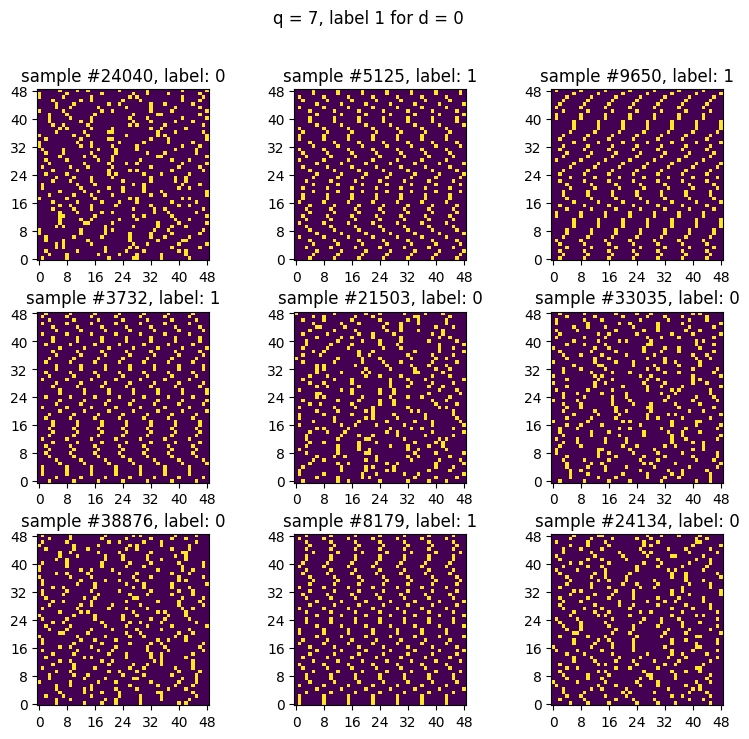


Epoch:  0


<ipython-input-13-1073461118ed>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Training batch accuracy: 91.63%
Validation batch accuracy: 100.00%

Epoch:  1
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  2
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  3
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  4
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  5
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  6
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  7
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  8
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  9
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  10
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  11
Training batch accuracy: 100.00%
Validation batch accuracy: 100.00%

Epoch:  12
Training batch accuracy: 100.00%
Validation batch 

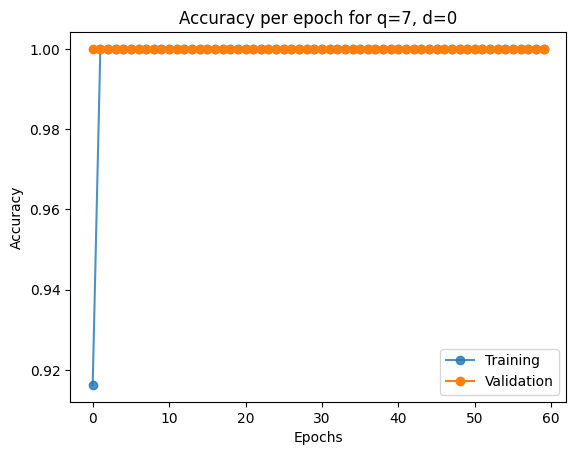

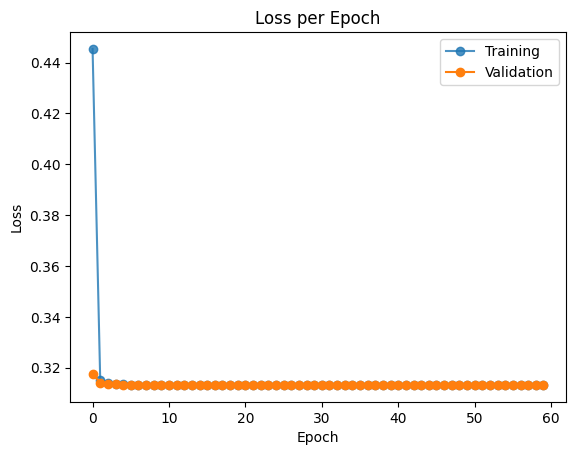

In [ ]:
q, d = 7, 0

net_q7_d0 = Net_coef_filter()
results_q7_d0 = run_model(net_q7_d0, q=q, d=d, num_instances=20000, num_epochs=60, pi=None)

Permutation pi:


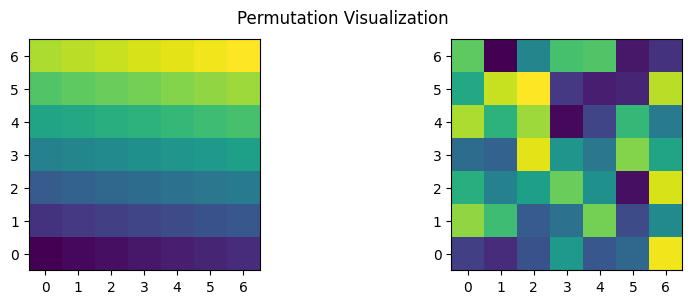

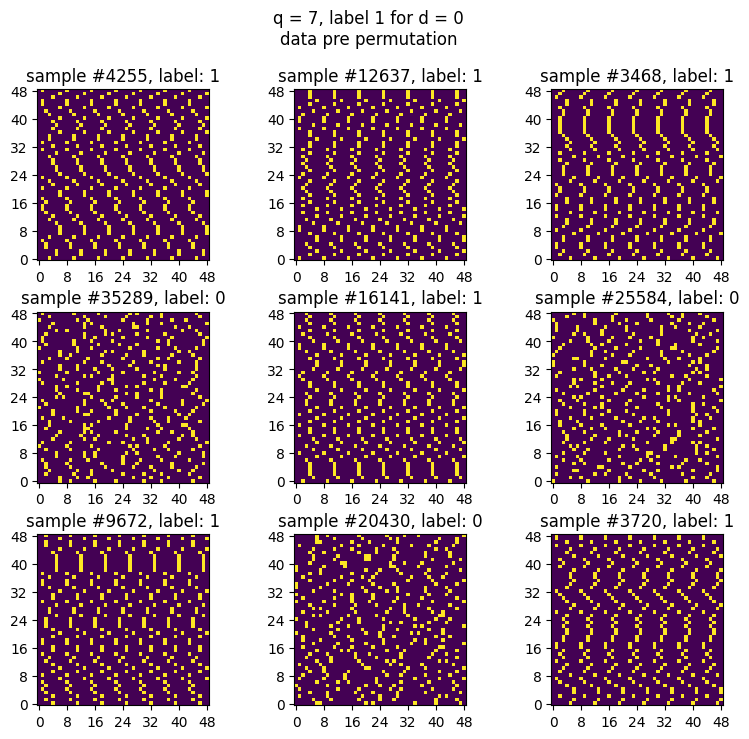

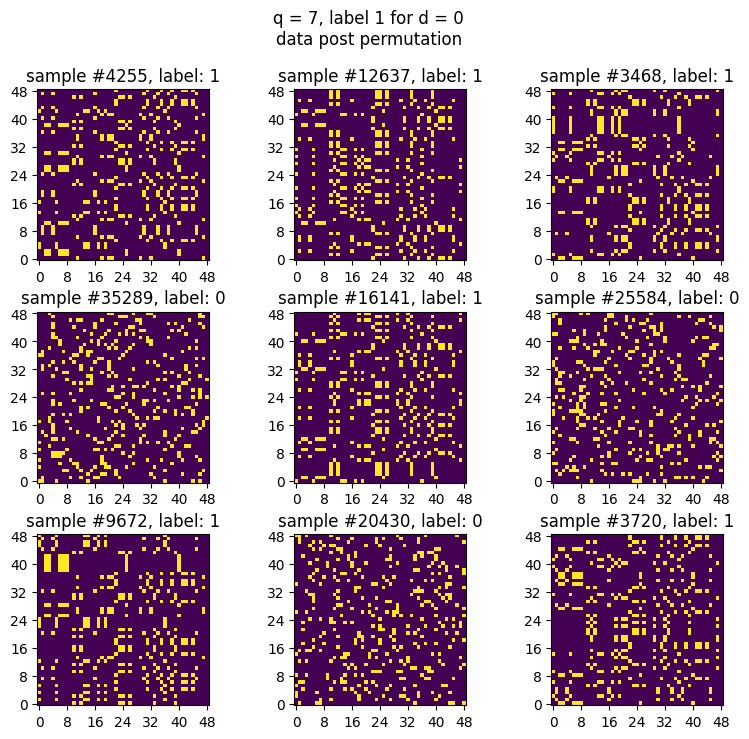


Epoch:  0


<ipython-input-13-1073461118ed>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Training batch accuracy: 90.12%
Validation batch accuracy: 99.74%

Epoch:  1
Training batch accuracy: 99.83%
Validation batch accuracy: 99.89%

Epoch:  2
Training batch accuracy: 99.92%
Validation batch accuracy: 99.91%

Epoch:  3
Training batch accuracy: 99.95%
Validation batch accuracy: 99.91%

Epoch:  4
Training batch accuracy: 99.98%
Validation batch accuracy: 99.95%

Epoch:  5
Training batch accuracy: 99.98%
Validation batch accuracy: 99.96%

Epoch:  6
Training batch accuracy: 99.98%
Validation batch accuracy: 99.96%

Epoch:  7
Training batch accuracy: 99.99%
Validation batch accuracy: 99.96%

Epoch:  8
Training batch accuracy: 99.99%
Validation batch accuracy: 99.98%

Epoch:  9
Training batch accuracy: 99.99%
Validation batch accuracy: 99.96%

Epoch:  10
Training batch accuracy: 99.99%
Validation batch accuracy: 99.96%

Epoch:  11
Training batch accuracy: 100.00%
Validation batch accuracy: 99.96%

Epoch:  12
Training batch accuracy: 100.00%
Validation batch accuracy: 99.96%

Epoc

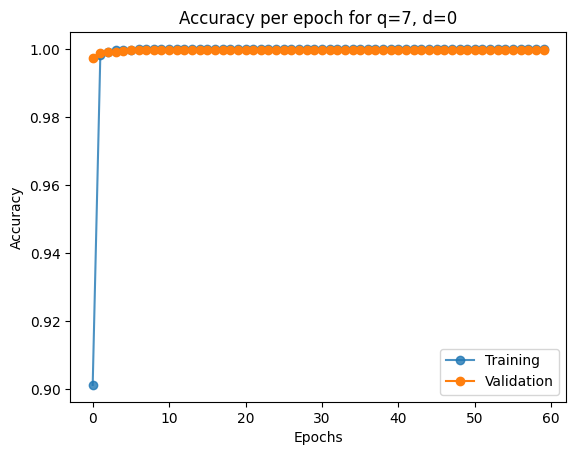

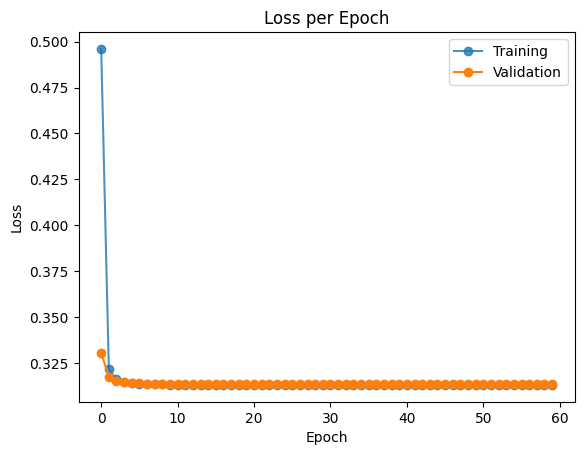

In [ ]:
q, d = 7, 0
pi = np.arange(q**2)
np.random.shuffle(pi)

net_q7_d2_perm = Net_coef_filter()
results_q7_d2_perm = run_model(net_q7_d2_perm, q=q, d=d, num_instances=20000, num_epochs=60, pi=pi)

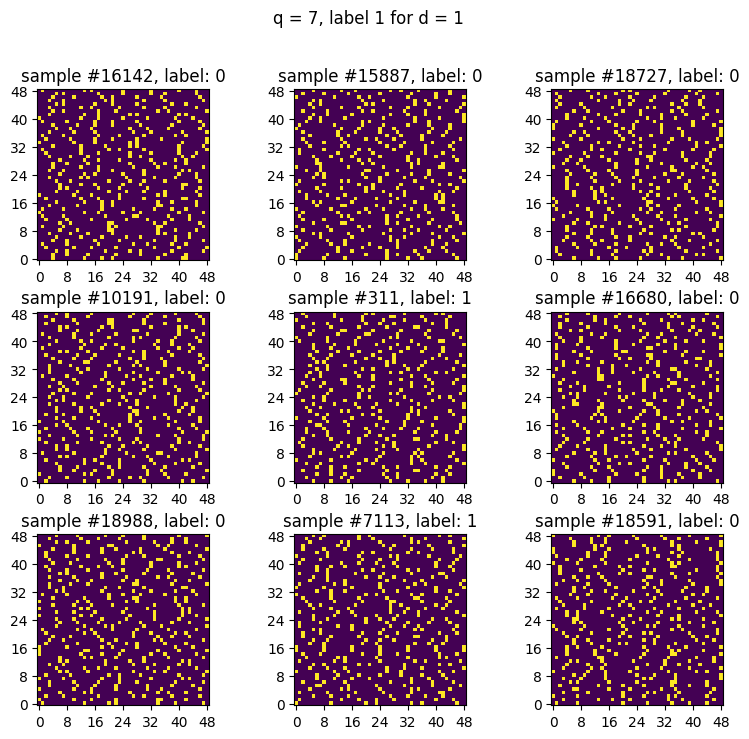


Epoch:  0


<ipython-input-36-1073461118ed>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Training batch accuracy: 50.22%
Validation batch accuracy: 50.00%

Epoch:  1
Training batch accuracy: 50.40%
Validation batch accuracy: 50.00%

Epoch:  2
Training batch accuracy: 51.00%
Validation batch accuracy: 50.62%

Epoch:  3
Training batch accuracy: 52.20%
Validation batch accuracy: 49.55%

Epoch:  4
Training batch accuracy: 54.97%
Validation batch accuracy: 50.18%

Epoch:  5
Training batch accuracy: 56.29%
Validation batch accuracy: 49.50%

Epoch:  6
Training batch accuracy: 57.23%
Validation batch accuracy: 49.68%

Epoch:  7
Training batch accuracy: 58.14%
Validation batch accuracy: 49.35%

Epoch:  8
Training batch accuracy: 58.20%
Validation batch accuracy: 49.95%

Epoch:  9
Training batch accuracy: 58.85%
Validation batch accuracy: 49.93%

Epoch:  10
Training batch accuracy: 59.06%
Validation batch accuracy: 50.05%

Epoch:  11
Training batch accuracy: 59.35%
Validation batch accuracy: 50.18%

Epoch:  12
Training batch accuracy: 59.48%
Validation batch accuracy: 49.95%

Epoch:

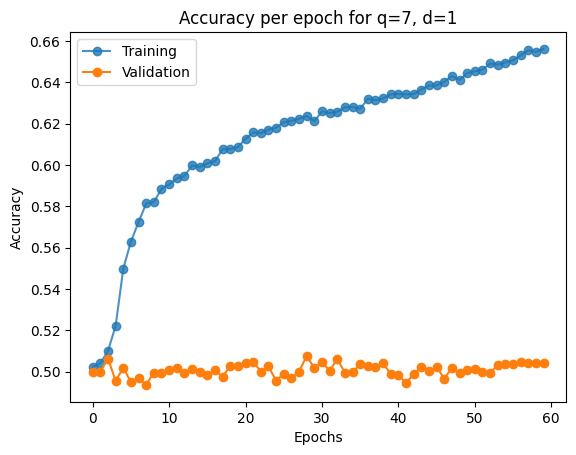

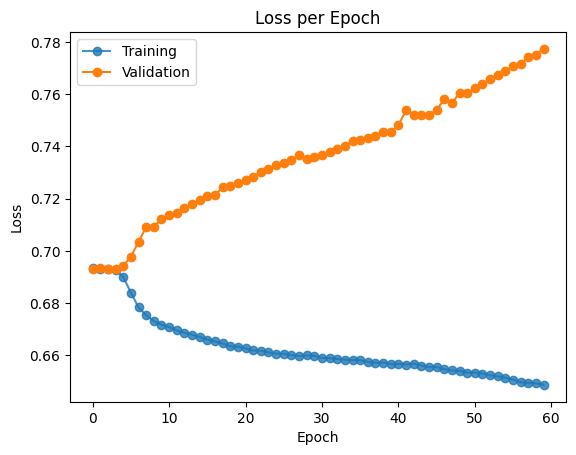

In [ ]:
q, d = 7, 1

net_q7_d1 = Net_coef_filter()
results_q7_d1 = run_model(net_q7_d1, q=q, d=d, num_instances=10000, num_epochs=60, pi=None)

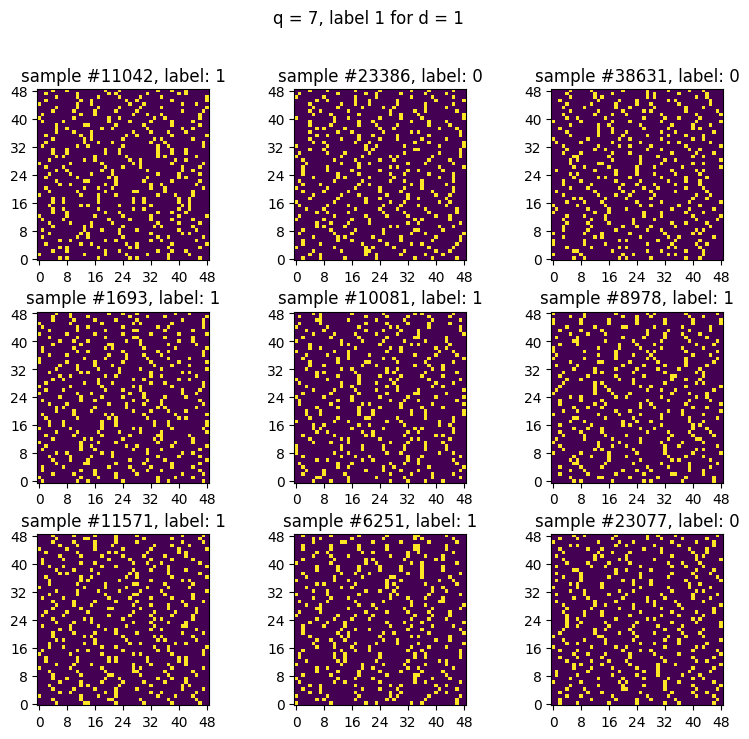


Epoch:  0


<ipython-input-36-1073461118ed>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Training batch accuracy: 50.31%
Validation batch accuracy: 50.00%

Epoch:  1
Training batch accuracy: 49.50%
Validation batch accuracy: 50.00%

Epoch:  2
Training batch accuracy: 49.94%
Validation batch accuracy: 50.00%

Epoch:  3
Training batch accuracy: 50.26%
Validation batch accuracy: 50.00%

Epoch:  4
Training batch accuracy: 50.30%
Validation batch accuracy: 50.00%

Epoch:  5
Training batch accuracy: 50.68%
Validation batch accuracy: 48.96%

Epoch:  6
Training batch accuracy: 52.31%
Validation batch accuracy: 51.08%

Epoch:  7
Training batch accuracy: 52.84%
Validation batch accuracy: 50.02%

Epoch:  8
Training batch accuracy: 52.92%
Validation batch accuracy: 49.24%

Epoch:  9
Training batch accuracy: 53.25%
Validation batch accuracy: 49.83%

Epoch:  10
Training batch accuracy: 53.14%
Validation batch accuracy: 49.96%

Epoch:  11
Training batch accuracy: 53.17%
Validation batch accuracy: 50.10%

Epoch:  12
Training batch accuracy: 53.41%
Validation batch accuracy: 50.14%

Epoch:

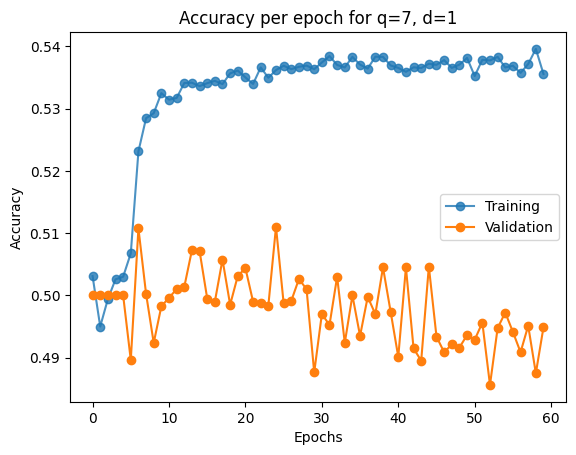

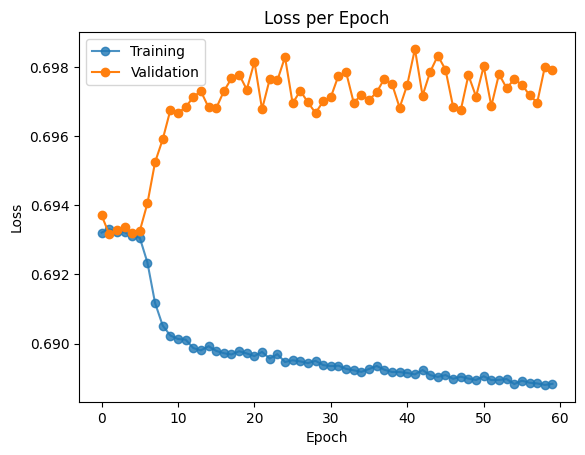

In [ ]:
q, d = 7, 1

net_q7_d1 = Net_coef_filter()
results_q7_d1 = run_model(net_q7_d1, q=q, d=d, num_instances=20000, num_epochs=60, pi=None)

Permutation pi:


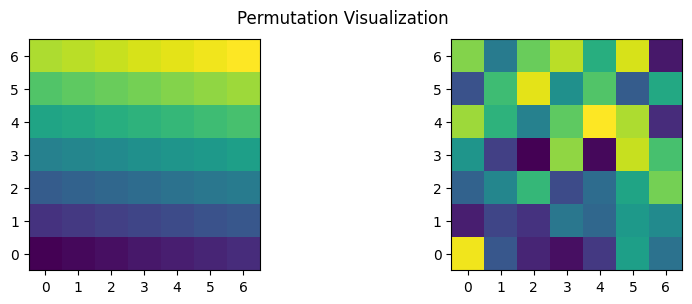

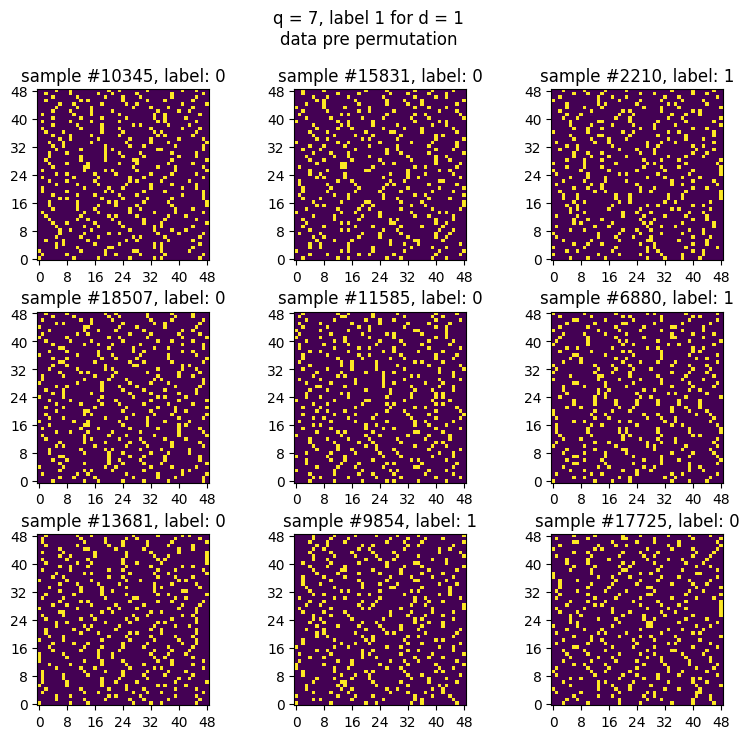

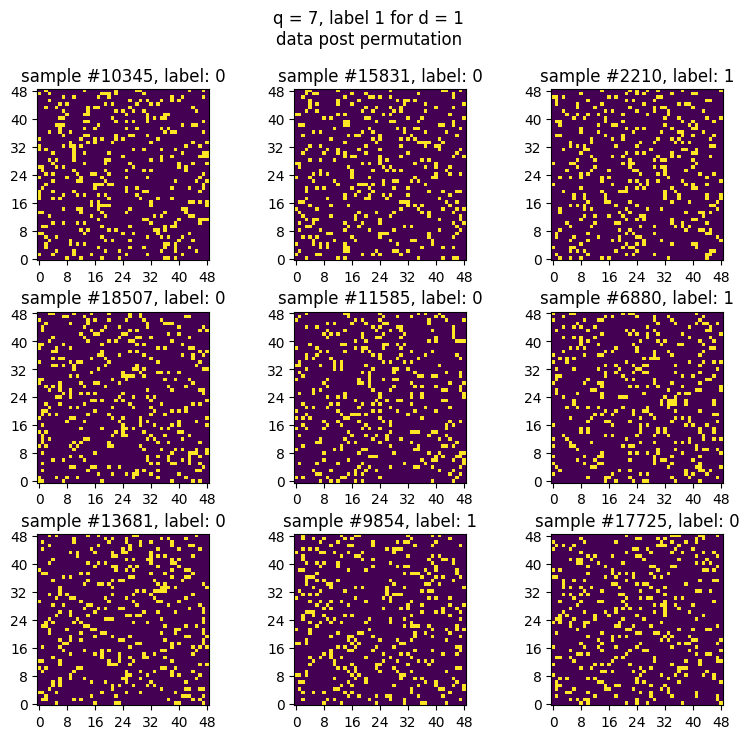


Epoch:  0


<ipython-input-36-1073461118ed>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Training batch accuracy: 49.50%
Validation batch accuracy: 50.00%

Epoch:  1
Training batch accuracy: 50.09%
Validation batch accuracy: 50.00%

Epoch:  2
Training batch accuracy: 49.96%
Validation batch accuracy: 50.00%

Epoch:  3
Training batch accuracy: 51.39%
Validation batch accuracy: 50.00%

Epoch:  4
Training batch accuracy: 52.11%
Validation batch accuracy: 50.75%

Epoch:  5
Training batch accuracy: 54.07%
Validation batch accuracy: 50.82%

Epoch:  6
Training batch accuracy: 54.82%
Validation batch accuracy: 51.20%

Epoch:  7
Training batch accuracy: 55.30%
Validation batch accuracy: 51.45%

Epoch:  8
Training batch accuracy: 55.66%
Validation batch accuracy: 51.98%

Epoch:  9
Training batch accuracy: 56.47%
Validation batch accuracy: 50.42%

Epoch:  10
Training batch accuracy: 56.97%
Validation batch accuracy: 50.78%

Epoch:  11
Training batch accuracy: 57.27%
Validation batch accuracy: 51.55%

Epoch:  12
Training batch accuracy: 57.24%
Validation batch accuracy: 51.92%

Epoch:

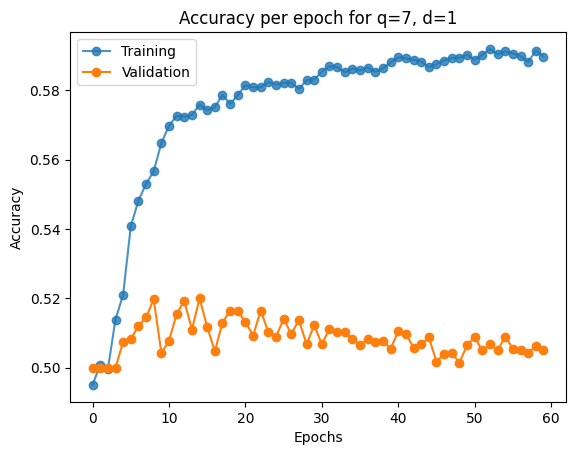

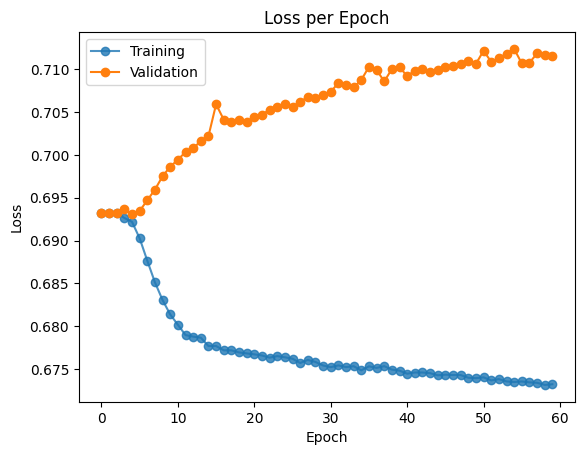

In [ ]:
q, d = 7, 1
pi = np.arange(q**2)
np.random.shuffle(pi)

net_q7_d1_perm = Net_coef_filter()
results_q7_d1_perm = run_model(net_q7_d1_perm, q=q, d=d, num_instances=10000, num_epochs=60, pi=pi)

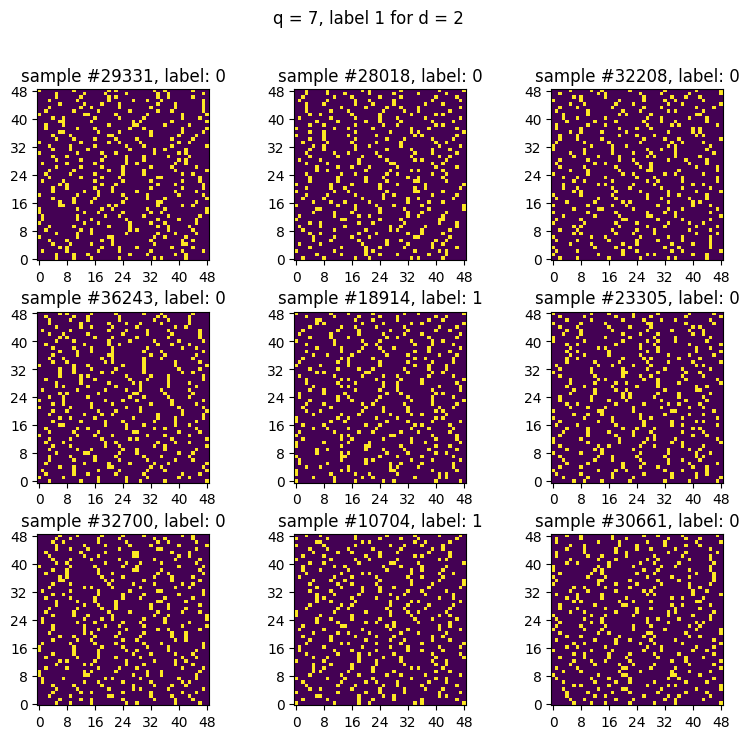


Epoch:  0


<ipython-input-36-1073461118ed>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Training batch accuracy: 50.06%
Validation batch accuracy: 50.00%

Epoch:  1
Training batch accuracy: 49.85%
Validation batch accuracy: 50.00%

Epoch:  2
Training batch accuracy: 49.95%
Validation batch accuracy: 50.00%

Epoch:  3
Training batch accuracy: 49.28%
Validation batch accuracy: 50.00%

Epoch:  4
Training batch accuracy: 50.27%
Validation batch accuracy: 50.00%

Epoch:  5
Training batch accuracy: 49.96%
Validation batch accuracy: 50.00%

Epoch:  6
Training batch accuracy: 50.24%
Validation batch accuracy: 50.00%

Epoch:  7
Training batch accuracy: 50.02%
Validation batch accuracy: 50.00%

Epoch:  8
Training batch accuracy: 50.13%
Validation batch accuracy: 50.00%

Epoch:  9
Training batch accuracy: 49.76%
Validation batch accuracy: 50.00%

Epoch:  10
Training batch accuracy: 49.69%
Validation batch accuracy: 50.00%

Epoch:  11
Training batch accuracy: 50.31%
Validation batch accuracy: 50.00%

Epoch:  12
Training batch accuracy: 49.72%
Validation batch accuracy: 50.00%

Epoch:

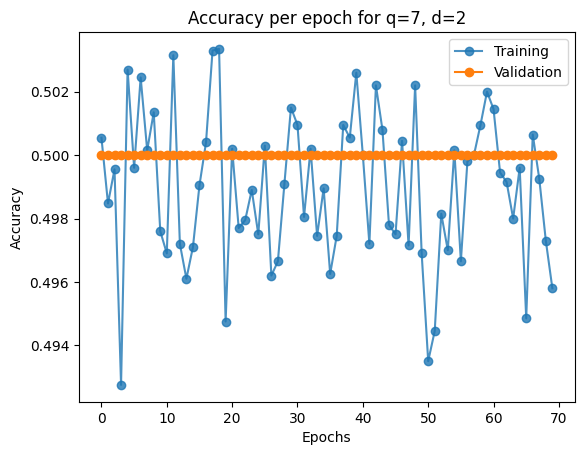

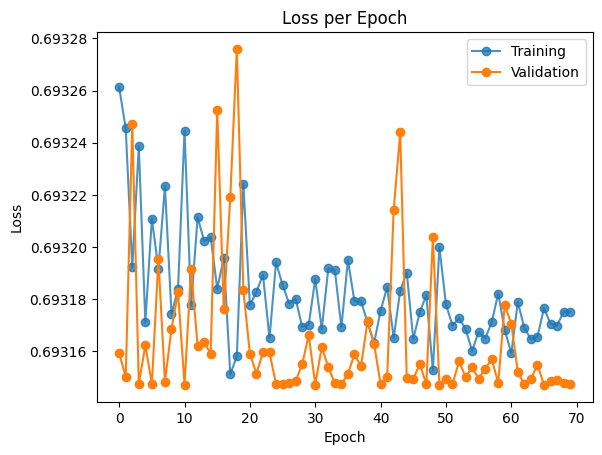

In [ ]:
q, d = 7, 2

net_q7_perm = Net_coef_filter()
results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=20000, num_epochs=70, pi=None)

In [ ]:
q, d = 7, 2
pi = np.arange(q**2)
np.random.shuffle(pi)

net_q7_perm = Net_coef_filter()
results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=pi)

In [ ]:
q, d = 7, 3

net_q7_pre = Net_coef_filter()
results_q7_pre = run_model(net_q7_pre, q=q, d=d, num_instances=10000, num_epochs=50, pi=None)

In [ ]:
q, d = 7, 3
pi = np.arange(q**2)
np.random.shuffle(pi)

net_q7_perm = Net_coef_filter()
results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=pi)

In [ ]:
q, d = 17, 1

net_q7_perm = Net_coef_filter()
results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=None)

In [ ]:
q, d = 17, 1

pi = np.arange(q**2)
np.random.shuffle(pi)

net_q7_perm = Net_coef_filter()
results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=pi)

In [ ]:
q, d = 17, 2

net_q7_perm = Net_coef_filter()
results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=None)

In [ ]:
q, d = 17, 2
pi = np.arange(q**2)
np.random.shuffle(pi)

net_q7_perm = Net_coef_filter()
results_q7_perm = run_model(net_q7_perm, q=q, d=d, num_instances=10000, num_epochs=50, pi=pi)